# Data Analysis

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import itertools

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
data_folder = "https://raw.githubusercontent.com/cdriscoll92/CS-109A-Final-Project/master/data/"
# local_data_folder = '/Users/poojatyagi/Dropbox (MIT)/CS 109A Final project/Data'
local_data_folder = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/data/"

In [5]:
combined_data = pd.read_csv(local_data_folder + "combined_data.csv")
combined_data[:5]

year dist_id  dem_vote_share  dem_vote_share_2018  dem_won_2018  congress  \
0  1980    AK_1        0.259215             0.458323           0.0      96.0   
1  1982    AK_1        0.288493             0.458323           0.0      97.0   
2  1984    AK_1        0.431049             0.458323           0.0      98.0   
3  1986    AK_1        0.421110             0.458323           0.0      99.0   
4  1988    AK_1        0.373454             0.458323           0.0     100.0   

     icpsr  nominate_dim1  nominate_dim2  nokken_poole_dim1  \
0  14066.0          0.279          0.014              0.220   
1  14066.0          0.279          0.014              0.249   
2  14066.0          0.279          0.014              0.216   
3  14066.0          0.279          0.014              0.196   
4  14066.0          0.279          0.014              0.212   

   nokken_poole_dim2   age  dem_incumbent  unemployment  
0              0.171  47.0              0           NaN  
1             -0.220  49.0              0           NaN  
2             -0.301  51.0              0           NaN  
3             -0.298  53.0              0           NaN  
4             -0.410  55.0              0           NaN

## Baseline model
Mathematically, this is: $P(D_{win} =1) = (1+e^{-\beta X + c})^{-1}$, where $\beta$ is composed of the combined results of each election between 1980 and 2016.

In [6]:
## Dropping unnecessary columns
cols_to_drop_for_train = ['dist_id', 'congress', 'icpsr']

# Fit logistic regression on training data 
data_to_fit_base = combined_data.drop(cols_to_drop_for_train,
                                      axis = 1,
                                      inplace = False)
data_to_fit_base = data_to_fit_base.dropna(inplace = False)
dem_vote_share_2018 = data_to_fit_base['dem_vote_share_2018'].values

In [7]:
## TRAINING SETS


x_train = data_to_fit_base
y_train = x_train.dem_won_2018.values



In [8]:
logreg_base = LogisticRegression(C=100000)
logreg_base.fit(x_train.dem_vote_share.values.reshape(-1, 1),
            y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
# Make Prediction and check the accuracy
y_train_probs=(logreg_base.predict_proba(x_train.dem_vote_share\
                                     .values.reshape(-1, 1)))

train_accuracy = logreg_base.score(x_train.dem_vote_share\
                               .values.reshape(-1, 1),
                            y_train)*100

print('Accuracy of baseline logistic regression classifier on train set: ',
      np.round(train_accuracy, 2), "%", sep = "")


Accuracy of baseline logistic regression classifier on train set: 75.15%


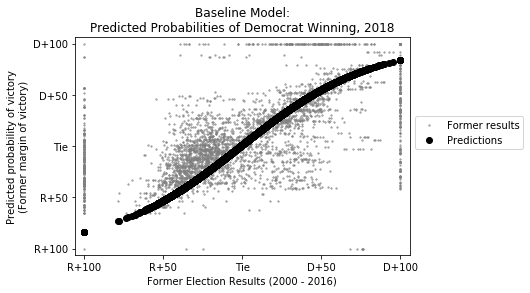

In [10]:
## True outcomes:
x_train_true = data_to_fit_base['dem_vote_share'].values
y_train_true = dem_vote_share_2018

# Plot predicted probabilities

x = np.arange(-0.2, 1.2, 0.01)
shade_alpha = 0.2

plt.plot(x_train_true, y_train_true, "*",
         color = "gray", markersize = 2,
         alpha = 0.5, label = "Former results")
plt.plot(x_train_true, y_train_probs[:,1],
         'o', color = "k",
         label='Predictions')
plt.xlabel('Former Election Results (2000 - 2016)')
plt.ylabel('Predicted probability of victory\n(Former margin of victory)')
plt.title('Baseline Model:\nPredicted Probabilities of Democrat Winning, 2018')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
          ["R+100", "R+50", "Tie","D+50","D+100"])
plt.yticks([0, 0.25, 0.5, 0.75, 1],
          ["R+100", "R+50", "Tie","D+50","D+100"])
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)
plt.legend(bbox_to_anchor=(1, 0.66))
plt.show();

## Adding to the Baseline Model

In [44]:
def add_power_terms(df, continuous_colnames, degree):
    if degree > 2 & degree % 1 == 0:
        for i in range(2, degree+1):
            for col in continuous_colnames:
                new_colname = col+"^"+str(i)
                df[new_colname] = df[col]**i
    else:
        if degree == 1:
            return(df)
        else:
            print("Invalid degree term")
    return(df)

def add_interaction_terms(df, continuous_colnames):
    binary_colnames = df.columns.difference(continuous_colnames)
    ## removing power terms
    binary_colnames = [x for x in binary_colnames if "^" not in x]
    
    for continuous_colname in continuous_colnames:
        for binary_colname in binary_colnames:
            interaction_colname = continuous_colname + "*" + binary_colname
            df[interaction_colname] = df[continuous_colname]*df[binary_colname]
    return(df)


In [11]:
## Dropping outcomes from x dataframe
x_train.drop(['dem_vote_share_2018','dem_won_2018'],
            axis = 1, inplace = True)

## Outcome vector is `y_train`

In [12]:
## Normalizing

In [52]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train)
x_train_scaled = pd.DataFrame(min_max_scaler.transform(x_train))
x_train_scaled.columns = x_train.columns
x_train_scaled.columns

Index(['year', 'dem_vote_share', 'nominate_dim1', 'nominate_dim2',
       'nokken_poole_dim1', 'nokken_poole_dim2', 'age', 'dem_incumbent',
       'unemployment'],
      dtype='object')

In [53]:
## Year * dem_vote_share
x_train_scaled['year*dem_vote_share'] = x_train_scaled['year'] *\
x_train_scaled['dem_vote_share']

In [54]:
## Splitting training and validation

tts_out = train_test_split(x_train_scaled, y_train,
                           test_size = 0.2,
                           random_state = 90,
                           stratify=x_train_scaled['year'])
x_train_scaled, x_val_scaled, y_train, y_val = tts_out

In [42]:
## Two options: One where NOMINATE scores are included;
## Second where Nokken/Poole scores are included


drop_cols1 = ['nokken_poole_dim1','nokken_poole_dim2']
drop_cols2 = ['nominate_dim1', 'nominate_dim2']
drop_cols = [drop_cols1, drop_cols2]


drop_cols

[['nokken_poole_dim1', 'nokken_poole_dim2'],
 ['nominate_dim1', 'nominate_dim2']]

In [63]:
poly_degree_max = 10
poly_degrees = range(1, poly_degree_max)
L2_penalties = [10**i for i in range(0,7,2)]

hyperparams = list(itertools.product(\
    *[L2_penalties,
      drop_cols,
     poly_degrees]))

In [64]:
hyperparams[0]

(1, ['nokken_poole_dim1', 'nokken_poole_dim2'], 1)

In [66]:
def get_design_mats(df, dropped_columns,
                    binary_columns, poly_degree):
    df_reduced = df.drop(dropped_columns, axis = 1,
                                  inplace = False)
    
    continuous_cols = [x for x in df_reduced.columns.values if \
                      x not in binary_columns]
    
    df_power = add_power_terms(df_reduced,
                               continuous_cols,
                               poly_degree)

    df_to_fit = add_interaction_terms(df_power,
                                      continuous_cols)
    return(df_to_fit)

In [69]:
def run_logit(x_train, x_val, y_train, y_val,
              hyperparams, binary_cols):
    
    C_i = hyperparams[0]
    dropped_cols = hyperparams[1]
    poly_degree = hyperparams[2]
    
    x_train_to_fit = get_design_mats(x_train, dropped_cols,
                                     binary_cols,
                                   poly_degree)
    x_val_to_fit = get_design_mats(x_val, dropped_cols,
                                   binary_cols,
                                   poly_degree)
    
    logit_obj = LogisticRegression(C=C_i)
    logit_obj.fit(x_train_to_fit,y_train)
    
    train_score = logit_obj.score(x_train_to_fit, y_train)
    val_score = logit_obj.score(x_val_to_fit, y_val)
    
    return(logit_obj, train_score, val_score)


In [70]:
logit_objects = []
train_scores = []
val_scores = []
for hp in hyperparams:
    logit_i = run_logit(x_train_scaled, x_val_scaled,
                        y_train, y_val,
                        hp, binary_cols = ['dem_incumbent'])
    logit_objects.append(logit_i[0])
    train_scores.append(logit_i[1])
    val_scores.append(logit_i[2])
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


(array([ 4.,  2.,  3.,  9., 12., 16., 15.,  3.,  4.,  4.]),
 array([0.76438356, 0.7669863 , 0.76958904, 0.77219178, 0.77479452,
        0.77739726, 0.78      , 0.78260274, 0.78520548, 0.78780822,
        0.79041096]),
 <a list of 10 Patch objects>)

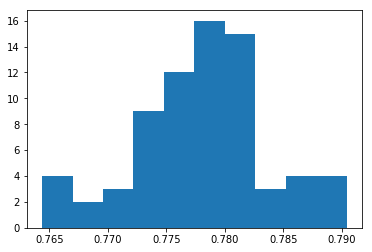

In [71]:
plt.hist(val_scores)

In [81]:
best_model_hps = hyperparams[np.argmax(val_scores)]
print("The model that performs best on cross-validation uses ",
      "L2 penalization term ",
      10**(-1*best_model_hps[0]),
      ", drops columns ", best_model_hps[1],
      ", and is of degree ", best_model_hps[2], sep = "")

The model that performs best on cross-validation uses L2 penalization term 0.0, drops columns ['nokken_poole_dim1', 'nokken_poole_dim2'], and is of degree 3
